# organise_annotation

Organise landmark annotation result on Zeno's face images and prepare the data for further processing.

## Step 1: Import modules

In [1]:
import os
import sys
import glob
import dlib
import time
import random
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
try:
    from ConfigParser import ConfigParser    # If using Python 2.7
except ImportError:
    from configparser import ConfigParser    # If using Python 3.5
config = ConfigParser()
config.read('config.ini')
sys.path.append(os.path.realpath(config.get('facial_landmark_tracker', 'repository_path')))
import ibug_face_tracker
from zeno_face_tracker_helpers import *
print('All modules imported.')

All modules imported.


## Step 2: Extract annotation result from the FAD files

In [2]:
# Get the annotated batches
annotated_batches = [float(x) for x in config.get('data_organisation', 'annotated_batches').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
batch_paths = []
for batch_index in annotated_batches:
    batch_name = 'batch_%03d' % int(batch_index)
    batch_suffix = ('%.03f' % abs(batch_index - int(batch_index)))[1:]
    if batch_suffix != '.000':
        batch_path = os.path.realpath(os.path.join('./dataset', batch_name + batch_suffix + '.fad'))
    else:
        batch_path = os.path.realpath(os.path.join('./dataset', batch_name + '.fad'))
    if os.path.exists(batch_path):
        batch_paths.append(batch_path)
        print('Batch found: ' + batch_path)
    else:
        print('Batch not found: ' + batch_path)

# Extract annotation result
images_processed = 0
last_check_time = time.time()
for batch_path in batch_paths:
    annotations = load_annotation_job(batch_path, config.getint('data_organisation', 
                                                                'number_of_landmarks'))
    for annotation in annotations:
        image = cv2.imread(annotation['image_path'])
        pts_path = os.path.splitext(annotation['image_path'])[0] + '.annot.pts'
        save_pts(pts_path, annotation['facial_landmarks'])
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, annotation['facial_landmarks'])
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, annotation['facial_landmarks'])
        cv2.imwrite(pts_path + '.png', image)
        images_processed += 1
        current_time = time.time()
        if last_check_time < current_time - 10.0:
            last_check_time = current_time
            print('Annotation of %d images have been extracted.' % images_processed)
print('Done, annotation of all %d images have been extracted.' % images_processed)

Batch found: D:\hhj\zeno_face_tracker\dataset\batch_000.fad
Batch found: D:\hhj\zeno_face_tracker\dataset\batch_001.fad
Batch found: D:\hhj\zeno_face_tracker\dataset\batch_010.fad
Batch found: D:\hhj\zeno_face_tracker\dataset\batch_011.fad
Annotation of 175 images have been extracted.
Done, annotation of all 349 images have been extracted.


## Step 3: Calculate mean shape from the annotation result

349 annotated samples and 851 unannotated samples loaded.
Mean shape has been saved to: D:\hhj\zeno_face_tracker\dataset\mean_shape.pts


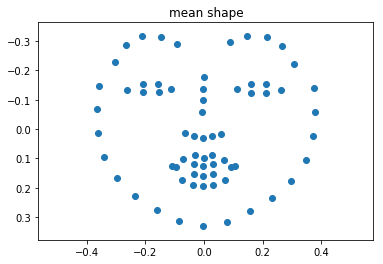

In [3]:
%matplotlib inline

# Load samples
annotations = []
valid_annotations = []
recording_sessions = sorted(glob.glob(os.path.realpath(os.path.join('./dataset', 'cam*'))))
recording_sessions = [x for x in recording_sessions if os.path.isdir(x)]
for session_path in recording_sessions:
    session_name = os.path.basename(session_path)
    image_files = sorted(glob.glob(os.path.join(session_path, '*.png')))
    image_files = [x for x in image_files if '.pts.png' not in x]
    for image_file in image_files:
        index = int(os.path.basename(image_file).split('.')[0])
        pts_file = os.path.splitext(image_file)[0] + '.annot.pts'
        if os.path.exists(pts_file):
            annotations.append({'session': session_name, 'index': index, 
                                'landmarks': load_pts(pts_file)})
            valid_annotations.append(annotations[-1])
        else:
            annotations.append({'session': session_name, 'index': index})
print('%d annotated samples and %d unannotated samples loaded.' % 
      (len(valid_annotations), len(annotations) - len(valid_annotations)))

# Calculate mean shape
all_landmarks = np.zeros((len(valid_annotations), 
                          valid_annotations[0]['landmarks'].shape[0], 
                          valid_annotations[0]['landmarks'].shape[1]))
for idx, annotation in enumerate(valid_annotations):
    landmarks = annotation['landmarks'] - annotation['landmarks'].mean(axis=0)
    face_size = np.linalg.norm(landmarks.max(axis=0) - landmarks.min(axis=0))
    landmarks = landmarks / face_size
    all_landmarks[idx] = landmarks
mean_shape = all_landmarks.mean(axis=0)

# Save mean shape
mean_shape_path = os.path.realpath(os.path.join('./dataset', 'mean_shape.pts'))
save_pts(mean_shape_path, mean_shape)
print('Mean shape has been saved to: ' + mean_shape_path)

# Show the mean shape
ax = plt.subplot(1, 1, 1)
plt.scatter(mean_shape[:, 0], mean_shape[:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('mean shape')
plt.show()

## Step 4: Align annotated landmarks to the mean shape

Done, 349 aligned landmark files saved.


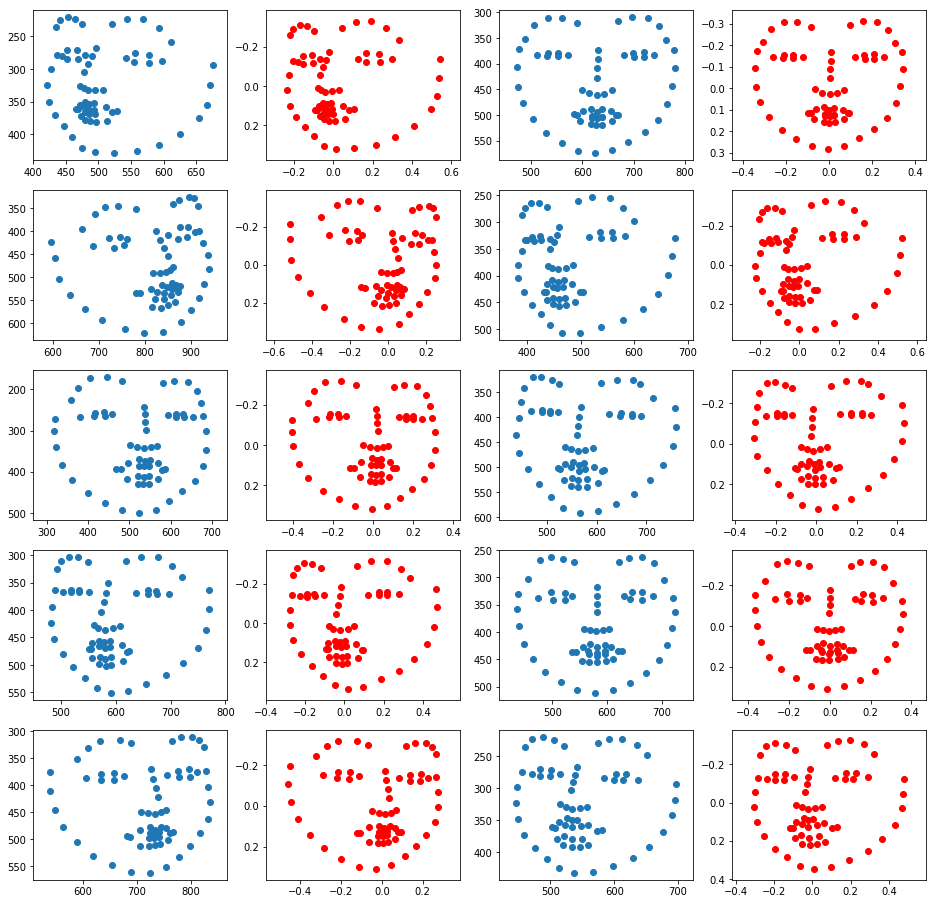

Shown above are the following randomly drawn examples (raw vs. aligned):
cam_m1/000008.annot.aligned.pts, cam_h4/000097.annot.aligned.pts
cam_h3/000077.annot.aligned.pts, cam_l3/000041.annot.aligned.pts
cam_m4/000060.annot.aligned.pts, cam_h4/000023.annot.aligned.pts
cam_h2/000002.annot.aligned.pts, cam_l3/000069.annot.aligned.pts
cam_h2/000026.annot.aligned.pts, cam_m1/000045.annot.aligned.pts


In [4]:
%matplotlib inline

# Align landmarks and save result
anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
for annotation in valid_annotations:
    annotation['aligned_landmarks'], _ = align_landmarks(
        annotation['landmarks'], mean_shape, anchors)
    pts_path = os.path.realpath(os.path.join('./dataset', annotation['session'], 
                                             '%06d.annot.aligned.pts' % annotation['index']))
    save_pts(pts_path, annotation['aligned_landmarks'], 6)
print('Done, %d aligned landmark files saved.' % len(valid_annotations))

# Randomly show 10 examples
examples_paths = []
matplotlib.rcParams['figure.figsize'] = [16, 16]
for idx, annotation in enumerate(random.sample(valid_annotations, 10)):
    ax = plt.subplot(5, 4, idx * 2 + 1)
    plt.scatter(annotation['landmarks'][:, 0], annotation['landmarks'][:, 1])
    ax.set_aspect('equal', 'datalim')
    ax.invert_yaxis()
    ax = plt.subplot(5, 4, idx * 2 + 2)
    plt.scatter(annotation['aligned_landmarks'][:, 0], 
                annotation['aligned_landmarks'][:, 1], c='r')
    ax.set_aspect('equal', 'datalim')
    ax.invert_yaxis()
    if idx % 2 == 0:
        paired_example_path = '%s/%06d.annot.aligned.pts' % (annotation['session'], 
                                                             annotation['index'])
    else:
        paired_example_path += ', %s/%06d.annot.aligned.pts' % (annotation['session'], 
                                                                annotation['index'])
        examples_paths.append(paired_example_path)
plt.show()
print('Shown above are the following randomly drawn examples (raw vs. aligned):\n' + 
      '\n'.join(examples_paths))

## Step 5: Combine landmarks with motor positions and face box and then save the result

In [5]:
# Load motor position records
session_record_paths = sorted(glob.glob(os.path.realpath(
    os.path.join('./dataset', 'cam*.pkl'))))
session_records = {}
for session_record_path in session_record_paths:
    session_name = os.path.splitext(os.path.basename(session_record_path))[0]
    session_records[session_name] = pd.read_pickle(session_record_path)
    print('Parsed: ' + session_record_path)

# Load face box annotation
annotated_face_boxes = {}
fad_paths = sorted(glob.glob(os.path.realpath(
    os.path.join('./dataset', 'batch*.face_box.fad'))))
for fad_path in fad_paths:
    face_boxes = load_annotation_job(fad_path, 4)
    for face_box in face_boxes:
        top_left = np.round(face_box['facial_landmarks'].min(axis=0)).astype(int)
        bottom_right = np.round(face_box['facial_landmarks'].max(axis=0)).astype(int)
        annotated_face_boxes[face_box['image_path']] = (top_left[0], top_left[1], 
                                                        bottom_right[0] - top_left[0] + 1, 
                                                        bottom_right[1] - top_left[1] + 1)

# Save everything into a single data frame, also get face bounding box for completeness
last_check_time = time.time()
face_detector = dlib.get_frontal_face_detector()
face_detection_scale = config.getfloat('facial_landmark_tracker', 'face_detection_scale')
face_detection_scale = max(face_detection_scale, 1e-6)
for idx, annotation in enumerate(annotations):
    session_record = session_records[annotation['session']]
    entry = session_record.loc[session_record['index'] == annotation['index']]
    annotation['motor_position'] = entry['motor_position'].values[0]
    annotation['time'] = entry['time'].values[0]
    image_path = os.path.realpath(os.path.join('./dataset', annotation['session'], 
                                               '%06d.png' % annotation['index']))
    if image_path in annotated_face_boxes:
        annotation['face_box'] = annotated_face_boxes[image_path]
    else:
        grayscale_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
        image_size = (grayscale_image.shape[1], grayscale_image.shape[0])
        target_size = (int(max(round(image_size[0] * face_detection_scale), 1)), 
                       int(max(round(image_size[1] * face_detection_scale), 1)))
        if target_size != image_size:
            face_detection_frame = cv2.resize(grayscale_image, target_size)
        else:
            face_detection_frame = grayscale_image
        detected_faces = sorted(
            [dlib.rectangle(int(round(face_box.left() / face_detection_scale)), 
                            int(round(face_box.top() / face_detection_scale)), 
                            int(round(face_box.right() / face_detection_scale)), 
                            int(round(face_box.bottom() / face_detection_scale))) 
             for face_box in face_detector(face_detection_frame)], 
            key=dlib.rectangle.area, reverse=True)
        if len(detected_faces) == 0 and target_size != image_size:
            detected_faces = sorted(face_detector(grayscale_image), 
                                    key=dlib.rectangle.area, reverse=True)
        if len(detected_faces) > 0:
            annotation['face_box'] = (detected_faces[0].left(), 
                                      detected_faces[0].top(), 
                                      detected_faces[0].width(), 
                                      detected_faces[0].height())
        else:
            print('Face detection failed in: ' + image_path)
    current_time = time.time()
    if last_check_time < current_time - 10.0:
        last_check_time = current_time
        print('%d samples have been processed.' % (idx + 1))
print('All %d samples have been processed.' % len(annotations))
package_path = os.path.realpath(os.path.join('./dataset', 'annotations.pkl'))
pd.DataFrame(annotations).to_pickle(package_path)
print('Everything is saved to: ' + package_path)

Parsed: D:\hhj\zeno_face_tracker\dataset\cam_h1.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_h2.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_h3.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_h4.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_l1.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_l2.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_l3.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_l4.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_m1.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_m2.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_m3.pkl
Parsed: D:\hhj\zeno_face_tracker\dataset\cam_m4.pkl
188 samples have been processed.
403 samples have been processed.
631 samples have been processed.
843 samples have been processed.
1047 samples have been processed.
All 1200 samples have been processed.
Everything is saved to: D:\hhj\zeno_face_tracker\dataset\annotations.pkl
